In [1]:
import pandas as pd
import numpy as np
import wrds
import seaborn as sns
import matplotlib.pyplot as plt

# Imports

In [2]:
# file imports
file_path_forecasts = '../data/dataset2014-2022-v4.zip'
file_path_company = '../data/dataset-company-industry-data-v1.csv'

# IBES forecasts
df_forecasts = pd.read_csv(file_path_forecasts)

# SIC codes
df_companies = pd.read_csv(file_path_company)

In [3]:
# setup WRDS database connection for linking table
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
# import linking information table
link_table = db.get_table(library = "comp", table = "security")
link_table = link_table[["gvkey", "iid", "ibtic"]]
link_table.head()

,gvkey,iid,ibtic
0,001000,01,None
1,001001,01,AMFD
2,001002,01,None
3,001003,01,ANTQ
4,001004,01,AIR


# Preprocessing
df_forecasts:
- Lower case all columns in df_forecasts
- Drop unncessary columns
- Include only forecasts issued no earlier than 1 year ahead and no later than 30 days before fiscal year end
- Rename columns
- Delete rows with actual_eps = NAN or estimated_eps = NAN
- (Exclude forecasts for companies which only one analyst provides a forecast)
- Exclude all analysts appearing in the initial 2-3 years of the dataset (migitating problem of experience)
- (Retain the last forecast an analyst issues in a particular year)
- ...

In [5]:
df_forecasts = df_forecasts.rename(columns={col: col.lower() for col in df_forecasts.columns})

# Drop unncessary columns
columns_to_drop = ["fpi","measure","cusip"]
df_forecasts = df_forecasts.drop(columns=columns_to_drop)

In [6]:
# convert columns with dates to datetime
def convert_to_datetime(df):
    columns_to_convert = ['fpedats','revdats', "anndats", 'anndats_act']
    for column in columns_to_convert:
        df[column] = pd.to_datetime(df[column])
    return df
df_forecasts = convert_to_datetime(df_forecasts)

# filter forecasts  based on time
df_forecasts['difference_date'] = df_forecasts['fpedats'] - df_forecasts['anndats']
df_forecasts = df_forecasts[(df_forecasts['difference_date']> pd.Timedelta(days=30))&(df_forecasts['difference_date']<pd.Timedelta(days=365))]
df_forecasts.head()

,ticker,oftic,cname,estimator,analys,value,fpedats,revdats,anndats,actual,anndats_act,difference_date
1,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
2,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
3,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days
4,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days
5,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days


In [7]:
# rename columns
df_forecasts = df_forecasts.rename(columns={"ticker": "ibes_ticker_pk", "oftic": "official_ticker", "analys": "analyst", 
                                  "value": "estimated_eps", "fpedats": "fiscal_period_ending", 
                                  "revdats": "revision_date", "anndats": "announce_date", 
                                  "actual": "actual_eps", "anndats_act": "announce_date_actual",
                                  "difference_date": "forecast_horizon"})

In [8]:
df_forecasts.head()

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon
1,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
2,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
3,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days
4,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days
5,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days


In [9]:
# drop all rows where the actual_eps is NaN and report number of rows dropped
print("Number of rows dropped: ", df_forecasts['actual_eps'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['actual_eps'])

Number of rows dropped:  39738


In [10]:
# drop all rows where the estimated_eps is NaN and report number of rows dropped
print("Number of rows dropped: ", df_forecasts['estimated_eps'].isna().sum())
df_forecasts = df_forecasts.dropna(subset=['estimated_eps'])

Number of rows dropped:  11


## Merging Industry Codes to IBES Forecasts

Get the PK of Compustat (gvkey) and append it to IBES dataframe with linking table provided by WRDS

In [11]:
# distinct ibtic values in link_table and distinct ibes_ticker_pk in df_forecasts
print("Number of distinct ibtic values in link_table: ", link_table['ibtic'].nunique())
print("Number of distinct ibes_ticker_pk values in df_forecasts: ", df_forecasts['ibes_ticker_pk'].nunique())

Number of distinct ibtic values in link_table:  27146
Number of distinct ibes_ticker_pk values in df_forecasts:  7255


In [12]:
# ibtic values that are in both link_table and df_forecasts
link_table_ibtic = link_table['ibtic'].unique()
df_forecasts_ibtic = df_forecasts['ibes_ticker_pk'].unique()
print("Number of ibtic values in link_table that are also in df_forecasts: ", len(set(link_table_ibtic).intersection(df_forecasts_ibtic)))

Number of ibtic values in link_table that are also in df_forecasts:  6027


In [13]:
# extract ibes_ticker_pk values that are not in link_table
ibtic_not_in_link_table = set(df_forecasts_ibtic).difference(link_table_ibtic)
ibtic_not_in_link_table

{'02S5',
 'GRNV',
 'ELRM',
 'CODG',
 'IPA',
 'TCRX',
 'ILAL',
 'GPAG',
 'JOBY',
 'SPI',
 'SBS2',
 'CIXP',
 'AXTO',
 'TDAC',
 'BJDX',
 '03RP',
 'NXPR',
 '00LK',
 '01BH',
 'LLDT',
 'GHRS',
 'ACRY',
 'CVT',
 'ASPLU',
 'SAFF',
 'WEAV',
 'SILV',
 'QTT',
 'ELYM',
 'SMGK',
 'CAHC',
 '0429',
 'CRER',
 '03PK',
 'ATMH',
 'EVCM',
 'SOPH',
 'LOMA',
 'MBOF',
 'TCBX',
 'ESDI',
 'RUM',
 'NTES',
 'CFLT',
 'NICX',
 'ACIC',
 'MERC',
 '03PW',
 '03TG',
 'ACOGF',
 'HOUR',
 'DTST',
 '020E',
 '03X1',
 'GBOO',
 'RIVN',
 'BDNF',
 'BTTX',
 'IDBA',
 'SIAG',
 'BEKE',
 'ABGO',
 '03U9',
 'ZENV',
 '03RM',
 'GLPG',
 'TMDI',
 'SPST',
 '04GP',
 'IMGO',
 'PSRO',
 'FENG',
 'SCVP',
 'DNNGY',
 '027Z',
 'COVF',
 'TOSB',
 'HMI',
 'JOBS',
 'BLDE',
 'CDHS',
 'GXO',
 'QNTQ',
 'PCWL',
 'DBVTF',
 'BCTX',
 'RSKD',
 '03LX',
 '03FT',
 'AVPT',
 'MQBK',
 'ISH',
 'VLNCF',
 'EFGI',
 'HTRF',
 'OCDDY',
 '03ND',
 '03JW',
 'CEG',
 'MOMO',
 'EVBE',
 'ANSF',
 'TNON',
 'NHEF',
 'ALZN',
 'BNTX',
 'SBFF',
 'NRDE',
 'GRRM',
 'YNDX',
 'VEJT',
 'VE

### Comment: Kick does we cant map?

In [14]:
# merge link table onto df_forecasts
merged_df = pd.merge(left = df_forecasts, right = link_table, how = "left", left_on="ibes_ticker_pk", right_on= "ibtic")
merged_df.head()

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,gvkey,iid,ibtic
0,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000
1,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000
2,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000
3,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days,192458,01,0000
4,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days,192458,01,0000


In [15]:
# metrics of successes
print("Number of rows df_forecasts: ", df_forecasts.shape[0])
print("Percentage of rows in merged_df that have no gvkey to total number of rows: ", (merged_df['gvkey'].isna().sum()/df_forecasts.shape[0])*100, "%")

Number of rows df_forecasts:  1375251
Percentage of rows in merged_df that have no gvkey to total number of rows:  9.943421237286866 %


### Merge SIC codes to IBES Forecasts table

In [16]:
# keep only first to integers of sic code for highest level of industry classification
df_companies['sic'] = df_companies['sic'].astype(str).str[:2]
df_companies["sic"].head()

0    50
1    50
2    50
3    50
4    50
Name: sic, dtype: object

In [17]:
# unique sic codes per gvkey in df_companies
sic_codes = df_companies[["gvkey", "sic"]].drop_duplicates().reset_index(drop=True)
sic_codes.head()

,gvkey,sic
0,1004,50
1,1019,73
2,1045,45
3,1050,35
4,1062,67


In [18]:
merged_df['gvkey'] = merged_df['gvkey'].astype(str)
sic_codes['gvkey'] = sic_codes['gvkey'].astype(str)

In [19]:
merged_df_sic = pd.merge(left=merged_df, right = sic_codes, how ="left", left_on = "gvkey", right_on="gvkey")
merged_df_sic.head()

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,gvkey,iid,ibtic,sic
0,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000,60
1,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000,60
2,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days,192458,01,0000,60
3,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days,192458,01,0000,60
4,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days,192458,01,0000,60


In [20]:
# how many rows have no sic code
print("Number of rows in merged_df_sic: ", merged_df_sic.shape[0])
print("Number of rows in merged_df_sic with no sic code: ", merged_df_sic['sic'].isna().sum())

Number of rows in merged_df_sic:  1376490
Number of rows in merged_df_sic with no sic code:  1012352


In [21]:
# how many gvkeys have no sic code
print("Number of gvkeys in merged_df_sic: ", merged_df_sic['gvkey'].nunique())
print("Number of gvkeys in merged_df_sic with no sic code: ", merged_df_sic[merged_df_sic['sic'].isna()]['gvkey'].nunique())

Number of gvkeys in merged_df_sic:  5975
Number of gvkeys in merged_df_sic with no sic code:  4138


# Accuracies

## Variant 1: PMAFE 
PMAFE is the proportional mean absolute forecast error

$$PMAFE = \frac{DAFE_{ijt}}{\overline{AFE_{jt}}} = \frac{AFE_{ijt} - \overline{AFE_{jt}}}{\overline{AFE_{jt}}} $$

where 
- $AFE_{ijt}$ is the absolute forecast error for analyst i's forecast of firm j for year t, and 
- $\overline{AFE_{jt}}$ is the mean absolute forecast error for firm j for year t

Negative PMAFE: better than average performance of analyst i (capped at -1.0)

Postive PMAFE: worse than average performance (theoretically towards infinity)

Source: Analyst forecast accuracy:
Do ability, resources, and
portfolio complexity matter?q
Michael B. Clement

In [22]:
df_forecasts.head()

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon
1,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
2,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days
3,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days
4,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days
5,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days


In [23]:
def calculate_pmafe(df):
    """
    This function first calculates the absolute forecast error for each analyst i forecast of firm j in year t
    If analyst i has multiple forecasts for firm j in year t, the function calculates the average forecast error
    In the second step an extra column is calculated for the overall forecast error is calculate for each firm j in year t
    In the third step, the function calculates the PMAFE for each analyst i forecast of firm j in year t
    This function adds new columns to the dataframe:
    - afe_analyst_i: the absolute forecast error for each analyst i forecast of firm j in year t
    - afe_analyst_i_avg: the average absolute forecast error for each analyst i forecast of firm j in year t
    - afe_mean_firm_j: the overall forecast error for each firm j in year t
    - pmafe: the PMAFE for each analyst i forecast of firm j in year t
    """
    # Step 1: Calculate the average absolute forecast error for each analyst i forecast of firm j in year t
    df['afe_analyst_i'] = np.abs(df['estimated_eps'] - df['actual_eps'])
    
    df_grouped = df.groupby(['ibes_ticker_pk', 'analyst', 'fiscal_period_ending']).agg({'afe_analyst_i': 'mean'}).reset_index()
    df_grouped = df_grouped.rename(columns={'afe_analyst_i': 'afe_analyst_i_avg'})
    df = pd.merge(df, df_grouped, on=['ibes_ticker_pk', 'analyst', 'fiscal_period_ending'], how='left')
    
    # Step 2: Calculate the overall forecast error for each firm j in year t
    df['afe_mean_firm_j'] = df.groupby(["ibes_ticker_pk", "fiscal_period_ending"])["afe_analyst_i"].transform("mean")
    
    # Step 3: Calculate the PMAFE for each analyst i forecast of firm j in year t
    df['pmafe'] = (df['afe_analyst_i_avg'] - df['afe_mean_firm_j']) / df['afe_mean_firm_j']
    
    return df

In [24]:
df_forecasts = calculate_pmafe(df_forecasts)
df_forecasts.head()

,ibes_ticker_pk,official_ticker,cname,estimator,analyst,estimated_eps,fiscal_period_ending,revision_date,announce_date,actual_eps,announce_date_actual,forecast_horizon,afe_analyst_i,afe_analyst_i_avg,afe_mean_firm_j,pmafe
0,0000,TLMR,TALMER BANCORP,2500,72481,0.85,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,0.17,0.198000,0.166786,0.187152
1,0000,TLMR,TALMER BANCORP,149,119962,0.86,2015-12-31,2015-02-18,2015-02-18,1.02,2016-01-26,316 days,0.16,0.174286,0.166786,0.044968
2,0000,TLMR,TALMER BANCORP,1267,71182,0.89,2015-12-31,2015-04-30,2015-02-18,1.02,2016-01-26,316 days,0.13,0.158000,0.166786,-0.052677
3,0000,TLMR,TALMER BANCORP,149,119962,0.89,2015-12-31,2015-04-30,2015-02-23,1.02,2016-01-26,311 days,0.13,0.174286,0.166786,0.044968
4,0000,TLMR,TALMER BANCORP,873,79092,0.91,2015-12-31,2015-07-06,2015-04-07,1.02,2016-01-26,268 days,0.11,0.136667,0.166786,-0.180585


### Descriptive Analysis PMAFE

In [46]:
# descriptive statistics of PMAFE grouped by analyst    
pmafe_by_analyst = df_forecasts.groupby("analyst")["pmafe"].describe()
pmafe_by_analyst

In [49]:
# How many companies are covered by the analysts with the most companies covered?
most_active_analyst = pmafe_by_analyst['count'].idxmax()
companies_covered = df_forecasts[df_forecasts['analyst'] == most_active_analyst]['ibes_ticker_pk'].nunique()
print(f"The most active analyst is {most_active_analyst} and he/she covers {companies_covered} companies.")

The most active analyst is 0 and he/she covers 563 companies.


In [38]:
# Whats the lowest and highest PMAFE?
print("The lowest PMAFE is: ", df_forecasts['pmafe'].min())
print("The highest PMAFE is: ", df_forecasts['pmafe'].max())

The lowest PMAFE is:  -1.0
The highest PMAFE is:  67.00421113621117


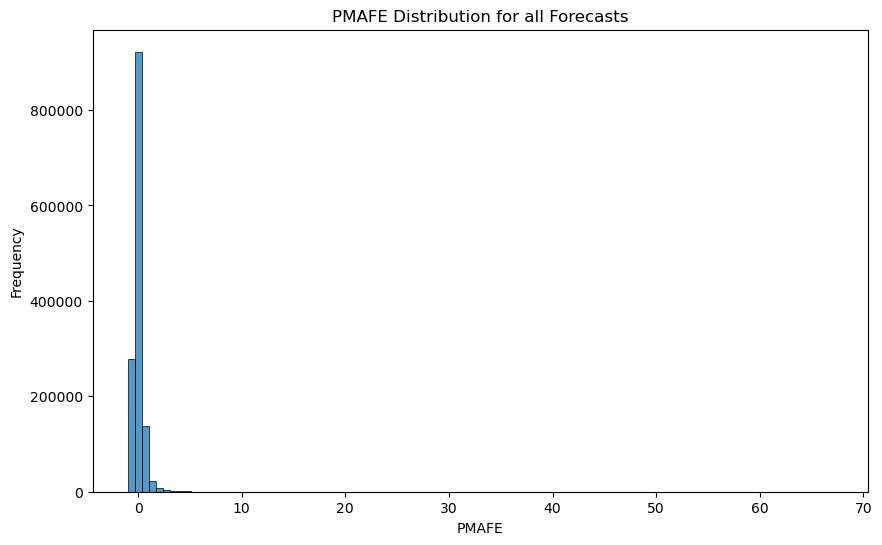

In [51]:
# most frequent PMAFE vales for all forecasts
plt.figure(figsize=(10, 6))
sns.histplot(df_forecasts['pmafe'], kde=False, bins=100)
plt.title("PMAFE Distribution for all Forecasts")
plt.xlabel("PMAFE")
plt.ylabel("Frequency")
plt.show()


C:\Users\mariu\AppData\Local\Temp\ipykernel_3152\3288892845.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_forecasts['pmafe'], shade=True)


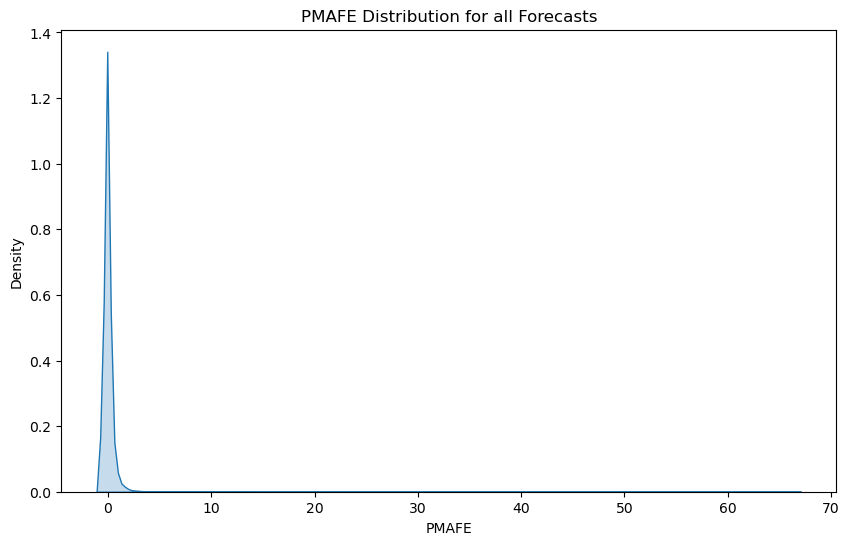

In [52]:
# density plot of PMAFE for all forecasts
plt.figure(figsize=(10, 6))
sns.kdeplot(df_forecasts['pmafe'], fill=True)
plt.title("PMAFE Distribution for all Forecasts")
plt.xlabel("PMAFE")
plt.ylabel("Density")
plt.show()

## Variant 2: Scaled accuracy

$$Acc_{ijt} = \frac{max AFE_{ijt} - AFE_{ijt}}{max AFE_{jt}- min AFE_{jt}}$$

where $max AFE_{jt}$ and $min AFE_{jt}$ are the maximum and minimum AFE for analysts following firm j in year t.

Source: Financial Analyst Characteristics and Herding Behavior in Forecasting MICHAEL B. CLEMENT and SENYO Y. TSE∗

In [ ]:
def calculate_scaled_acc(df):
    """_summary_
    
    Args:
        df (_type_): _description_
    """
    return df

# Export df

In [25]:
# write to csv
# name of the file to be saved as df_forecasts_pmafe.csv
df_forecasts.to_csv("../data/processed/forecasts_pmafe.csv", index=False)